# Decision Trees - Class Exercise 3

## Introduction

The Cleveland Heart Disease Dataset, hosted by the UCI Machine Learning Repository, is a cornerstone in the field of medical informatics for predicting the presence of heart disease in patients. This dataset comprises 303 individual records, each described by 14 variables, including age, sex, chest pain type, resting blood pressure, serum cholesterol levels, fasting blood sugar, resting electrocardiographic results, maximum heart rate achieved, exercise-induced angina, and others. The target variable indicates the presence or absence of heart disease.

Originally contributed by the Cleveland Clinic Foundation, this dataset has been widely used for benchmarking machine learning models in binary classification tasks, where the objective is to accurately predict whether or not a patient has heart disease based on their medical measurements. It serves not only as a practical dataset for predictive modeling but also as a valuable resource for exploring machine learning techniques in healthcare applications.

Our goal is to build a decision tree a model to predict whether a patient has heart disease or not.

## Metadata

| Variables     | Description                                                 |
|---------------|-------------------------------------------------------------|
| age           | Age of patient (in years)                                   |
| sex           | Gender of patient (0 = female; 1 = male)                    |
| cp            | Chest pain type (1: typical angina; 2: atypical angina; 3: non-anginal pain; 4: asymptomatic) |
| restbps       | Resting blood pressure on admission to hospital (in mmHg)   |
| chol          | Serum cholesterol (in mg/dl)                                |
| fbs           | Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)       |
| restecg       | Resting electrocardiographic results (values 0, 1, 2)       |
| thalach       | Maximum heart rate achieved                                 |
| exang         | Exercise induced angina (1 = yes; 0 = no)                   |
| oldpeak       | ST depression induced by exercise relative to rest          |
| slope         | Slope of the peak exercise ST segment (values 1, 2, 3)      |
| ca            | Number of major vessels colored by fluoroscopy (0 to 4)     |
| thal          | 3 = normal; 6 = fixed defect; 7 = reversible defect         |
| target        | Presence (Yes) or absence (No) of heart disease             |



## Import necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

## Import data

In [2]:
df = pd.read_csv('Heart Disease.csv')
df

,age,sex,cp,restbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


## Check for missing values

In [3]:
missing_values = df.isnull().sum()
missing_values

age        0
sex        0
cp         0
restbps    0
chol       0
fbs        0
restecg    0
thalach    0
exang      0
oldpeak    0
slope      0
ca         0
thal       0
target     0
dtype: int64

We observe that there are no missing values in the dataset.

## One-hot encoding for multiclass variables

To prevent the potential problem of *spurious ordering* in multiclass variables with ```K>2``` classes, we will apply one-hot encoding to transform all of them into separate ```K-1``` binary vectors.

In [4]:
# Initialize encoder
encoder = OneHotEncoder(drop='first', sparse_output=False)

# Declare all multiclass variables with K>2 classes
multiclass_columns = ['cp', 'restecg', 'slope', 'thal']

# Encode multiclass variables with K>2 classes
for column in multiclass_columns:
    encoded_result = encoder.fit_transform(df[[column]])
    encoded_df = pd.DataFrame(encoded_result, columns=encoder.get_feature_names_out([column]))
    # Drop original column and concatenate the new one-hot encoded DataFrame
    df.drop(column, axis=1, inplace=True)
    df = pd.concat([df, encoded_df], axis=1)

df.head()

,age,sex,restbps,chol,fbs,thalach,exang,oldpeak,ca,target,cp_1,cp_2,cp_3,restecg_1,restecg_2,slope_1,slope_2,thal_1,thal_2,thal_3
0,63,1,145,233,1,150,0,2.3,0,1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,37,1,130,250,0,187,0,3.5,0,1,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,41,0,130,204,0,172,0,1.4,0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,56,1,120,236,0,178,0,0.8,0,1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,57,0,120,354,0,163,1,0.6,0,1,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


## Train-test split

In [5]:
X = df.drop('target', axis=1)
y = df['target']

In [6]:
# Specify split parameters
random_seed = 9002
test_size = 0.2

# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_seed)

In [7]:
print('Size of train set: ', len(X_train))
print('Size of test set: ', len(X_test))

Size of train set:  242
Size of test set:  61


## Train model

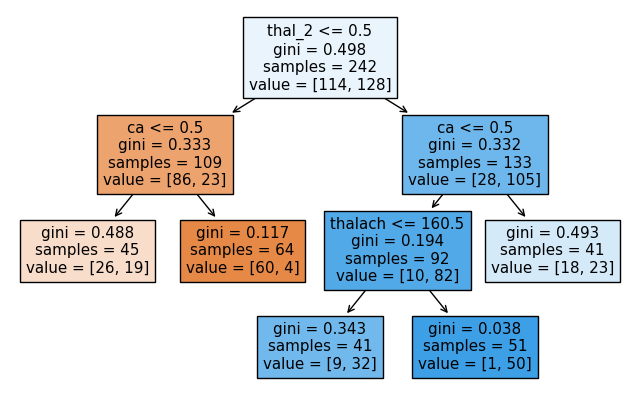

In [8]:
# Specify model parameters
criterion = 'gini'
min_samples_leaf = 40

# Build model
model = DecisionTreeClassifier(criterion=criterion, min_samples_leaf=min_samples_leaf)

# Fit model on training data
model.fit(X_train, y_train)

# Visualize the decision tree
feature_names = X_train.columns.tolist()
plt.figure(figsize=(8, 5))
plot_tree(model, filled=True, feature_names=feature_names)
plt.show()

## Evaluate model

In [9]:
# Predict test data
y_pred = model.predict(X_test)

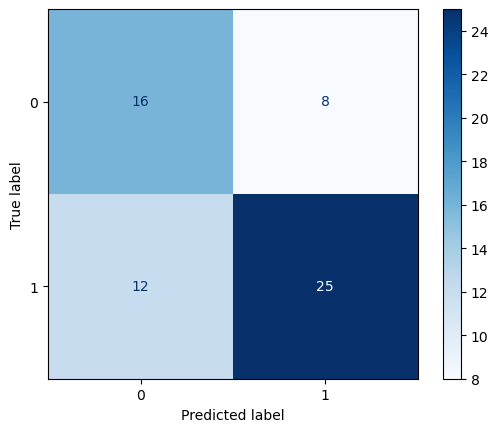

In [10]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [11]:
# Check test accuracy
accuracy_test = accuracy_score(y_test, y_pred)
print(f"Test accuracy: {accuracy_test:.2f}")

Test accuracy: 0.67


## Model improvement

To improve the model, we will experiment with two hyperparameters:
* ```criterion```
* ```min_samples_leaf```

We will first define the hyperparameter grid for ```criterion``` and ```min_samples_leaf```, which contains values for these two hyperparameters that we will be experimenting with. Then, we will use ```GridSearchCV``` to perform a grid search to obtain the optimal values of the two hyperparameters.

In [12]:
# Define hyperparameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'min_samples_leaf': [10, 20, 30, 40, 50, 60, 70, 80]
}

In [13]:
# Perform grid search with 10-fold cross-validation
model = DecisionTreeClassifier()
cv = KFold(n_splits=10, shuffle=True, random_state=9002)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train);

In [14]:
# Display best params and best validation score
print("Best parameters:", grid_search.best_params_)
print(f"Best average cross-validation score: {grid_search.best_score_:.2f}")

Best parameters: {'criterion': 'gini', 'min_samples_leaf': 30}
Best average cross-validation score: 0.79


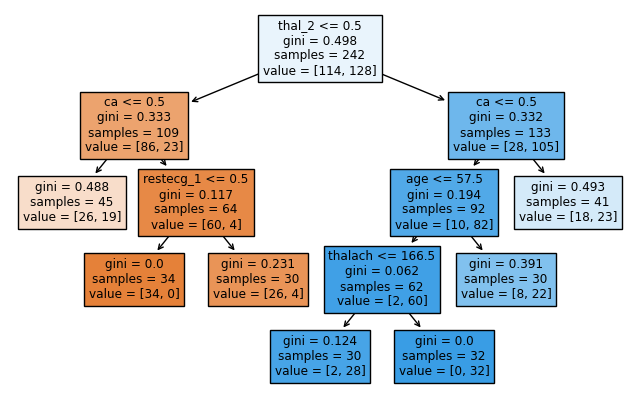

In [15]:
# Fit optimal model using best params found above
optimal_model = grid_search.best_estimator_

# Visualize the optimal decision tree
plt.figure(figsize=(8, 5))
plot_tree(optimal_model, filled=True, feature_names=feature_names)
plt.show()

In [16]:
# Apply the optimal model on the test data
y_test_pred = optimal_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test accuracy: {test_accuracy:.2f}")

Test accuracy: 0.67


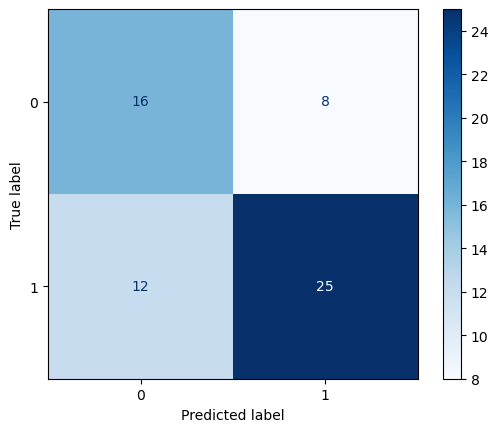

In [17]:
# Generate confusion matrix for optimal model
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()